In [1]:
import numpy as np
import pandas as pd
import anndata
import scipy.stats as stats
import h5py
from grelu.visualize import plot_attributions
from grelu.interpret.motifs import trim_pwm
import os, sys

sys.path.append('/code/decima/src/decima')
from interpret import read_meme_file
from visualize import plot_logo

from plotnine import *
%matplotlib inline

/usr/local/lib/python3.11/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
save_dir="/gstore/data/resbioai/grelu/decima/20240823/"
matrix_file = os.path.join(save_dir, "data.h5ad")
h5_file = os.path.join(save_dir, "data.h5")
ckpt_dir = os.path.join(save_dir, 'lightning_logs')

In [3]:
ad = anndata.read_h5ad(matrix_file)
ad = ad[:, ad.var.dataset=="test"]

## Make disease anndatas

In [38]:
## Crohns
disease = "Crohn's disease"
ad_crohns = ad[(ad.obs.study== '17481d16-ee44-49e5-bcf0-28c0780d8c4a') &\
    (ad.obs.tissue=='ileum') & (ad.obs.disease.isin(['healthy', disease]))].copy()
sel_cts = ad_crohns.obs.cell_type.value_counts()[ad_crohns.obs.cell_type.value_counts()==2].index.tolist()
ad_crohns = ad_crohns[ad_crohns.obs.cell_type.isin(sel_cts)]

d = ad_crohns[ad_crohns.obs.disease==disease]
h = ad_crohns[ad_crohns.obs.disease=='healthy']

d.obs.index = d.obs_names = d.obs.cell_type.tolist()
h.obs.index = h.obs_names = h.obs.cell_type.tolist()
d = d[sel_cts]
h = h[sel_cts]

obs = pd.DataFrame({'h_cells':h.obs['n_cells'].tolist(), 'd_cells':d.obs['n_cells'].tolist()}, index=sel_cts)
ad_crohns = anndata.AnnData(obs=obs, var=h.var)
ad_crohns.layers['true_lfc'] = d.X - h.X
ad_crohns.layers['pred_lfc'] = d.layers['preds'] - h.layers['preds']

ad_crohns.obs['corr'] = [
    np.round(np.corrcoef(
        ad_crohns.layers['true_lfc'][i], ad_crohns.layers['pred_lfc'][i]
    )[0, 1], 2) for i in range(ad_crohns.shape[0])
]

for ct in ['fibroblast', 'enterocyte', 'goblet cell']:
    ad_crohns.var.loc[ad_crohns[ct].layers['true_lfc'].squeeze() > 1, f'{ct}_direction'] = 'Upregulated'
    ad_crohns.var.loc[ad_crohns[ct].layers['true_lfc'].squeeze() < -1, f'{ct}_direction'] = 'Downregulated'

In [39]:
## Scleroderma
disease = "scleroderma"
ad_sc = ad[(ad.obs.study=='GSE128169') & (ad.obs.disease.isin([disease, 'healthy'])) & (ad.obs.tissue=='lung')].copy()
sel_cts = ad_sc.obs.cell_type.value_counts()[ad_sc.obs.cell_type.value_counts()==2].index.tolist()
ad_sc = ad_sc[ad_sc.obs.cell_type.isin(sel_cts)]

d = ad_sc[ad_sc.obs.disease==disease]
h = ad_sc[ad_sc.obs.disease=='healthy']
d.obs.index = d.obs_names = d.obs.cell_type.tolist()
h.obs.index = h.obs_names = h.obs.cell_type.tolist()
d = d[sel_cts]
h = h[sel_cts]

obs = pd.DataFrame({'h_cells':h.obs['n_cells'].tolist(), 'd_cells':d.obs['n_cells'].tolist()}, index=sel_cts)
ad_sc = anndata.AnnData(obs=obs, var=h.var)
ad_sc.layers['true_lfc'] = d.X - h.X
ad_sc.layers['pred_lfc'] = d.layers['preds'] - h.layers['preds']

ad_sc.obs['corr'] = [
    np.round(np.corrcoef(
        ad_sc.layers['true_lfc'][i], ad_sc.layers['pred_lfc'][i]
    )[0, 1], 2) for i in range(ad_sc.shape[0])
]    

## Scatter plots

In [ ]:
ct = 'fibroblast'
df = pd.DataFrame({
    'true':ad_crohns[ct].layers['true_lfc'].squeeze(),
    'pred':ad_crohns[ct].layers['pred_lfc'].squeeze(),
})
(
    ggplot(df, aes(x='true', y='pred')) + geom_pointdensity(size=.1) 
    + theme_classic() + theme(figure_size=(2.7, 2.7))
    + geom_abline(slope=1, intercept=0) + ggtitle("    Fibroblast\nCrohn's Disease")
    + geom_hline(yintercept=0, linetype='--') + geom_vline(xintercept=0, linetype='--')
    + xlab('   Measured logFC\n(disease vs. healthy)') 
    + ylab('   Predicted logFC\n(disease vs. healthy)')
)

In [ ]:
ct = 'enterocyte'
df = pd.DataFrame({
    'true':ad_crohns[ct].layers['true_lfc'].squeeze(),
    'pred':ad_crohns[ct].layers['pred_lfc'].squeeze(),
})
(
    ggplot(df, aes(x='true', y='pred')) + geom_pointdensity(size=.1) 
    + theme_classic() + theme(figure_size=(2.7, 2.7))
    + geom_abline(slope=1, intercept=0) + ggtitle("    Fibroblast\nCrohn's Disease")
    + geom_hline(yintercept=0, linetype='--') + geom_vline(xintercept=0, linetype='--')
    + xlab('   Measured logFC\n(disease vs. healthy)') 
    + ylab('   Predicted logFC\n(disease vs. healthy)')
)

In [ ]:
ct = 'fibroblast'
df = pd.DataFrame({
    'true':ad_sc[ct].layers['true_lfc'].squeeze(),
    'pred':ad_sc[ct].layers['pred_lfc'].squeeze(),
})
(
    ggplot(df, aes(x='true', y='pred')) + geom_pointdensity(size=.1) 
    + theme_classic() + theme(figure_size=(2.7, 2.7))
    + geom_abline(slope=1, intercept=0) + ggtitle("    Fibroblast\nScleroderma")
    + geom_hline(yintercept=0, linetype='--') + geom_vline(xintercept=0, linetype='--')
    + xlab('   Measured logFC\n(disease vs. healthy)') 
    + ylab('   Predicted logFC\n(disease vs. healthy)')
)

In [ ]:
ct = 'type II pneumocyte'
df = pd.DataFrame({
    'true':ad_sc[ct].layers['true_lfc'].squeeze(),
    'pred':ad_sc[ct].layers['pred_lfc'].squeeze(),
})
(
    ggplot(df, aes(x='true', y='pred')) + geom_pointdensity(size=.1) 
    + theme_classic() + theme(figure_size=(2.7, 2.7))
    + geom_abline(slope=1, intercept=0) + ggtitle("Type II pneumocyte\n    Scleroderma")
    + geom_hline(yintercept=0, linetype='--') + geom_vline(xintercept=0, linetype='--')
    + xlab('   Measured logFC\n(disease vs. healthy)') 
    + ylab('   Predicted logFC\n(disease vs. healthy)')
)

## Upregulated / downregulated plots

In [112]:
max_bg_for_specific=1
min_bg_for_nonspecific=1
min_n_cells = 500

In [125]:
ct='fibroblast'

max_bg = np.max(ad_crohns.layers['true_lfc'][
        (ad_crohns.obs_names!=ct) & (ad_crohns.obs.h_cells > min_n_cells) & (ad_crohns.obs.d_cells > min_n_cells)], 0)
min_bg = np.min(ad_crohns.layers['true_lfc'][
        (ad_crohns.obs_names!=ct) & (ad_crohns.obs.h_cells > min_n_cells) & (ad_crohns.obs.d_cells > min_n_cells)], 0)
ad_crohns.var['direction'] = None
ad_crohns.var['specificity'] = None
ad_crohns.var.loc[ad_crohns[ct].layers['true_lfc'].squeeze() > 1, 'direction'] = 'Upregulated'
ad_crohns.var.loc[ad_crohns[ct].layers['true_lfc'].squeeze() < -1, 'direction'] = 'Downregulated'
ad_crohns.var.loc[(ad_crohns.var['direction']=='Upregulated') & (max_bg > min_bg_for_nonspecific), 'specificity'] = 'Nonspecific'
ad_crohns.var.loc[(ad_crohns.var['direction']=='Upregulated') & (max_bg < max_bg_for_specific), 'specificity'] = 'Specific'
ad_crohns.var.loc[(ad_crohns.var['direction']=='Downregulated') & (min_bg < -min_bg_for_nonspecific), 'specificity'] = 'Nonspecific'
ad_crohns.var.loc[(ad_crohns.var['direction']=='Downregulated') & (min_bg > -max_bg_for_specific), 'specificity'] = 'Specific'
tp = ad_crohns.var[['direction', 'specificity']].copy()
tp['pred'] = np.array(ad_crohns[ct].layers['pred_lfc']).squeeze()
tp = tp[(tp['direction'].isin(['Upregulated', 'Downregulated'])) & (tp.specificity.isin(['Nonspecific', 'Specific']))]
print(ct, "Crohn's")
print(stats.wilcoxon(tp[(tp['direction'] == 'Upregulated') & (tp.specificity == 'Specific')].pred, alternative='greater').pvalue)
print(stats.wilcoxon(tp[(tp['direction'] == 'Upregulated') & (tp.specificity == 'Nonspecific')].pred, alternative='greater').pvalue)
print(stats.wilcoxon(tp[(tp['direction'] == 'Downregulated') & (tp.specificity == 'Specific')].pred, alternative='less').pvalue)
print(stats.wilcoxon(tp[(tp['direction'] == 'Downregulated') & (tp.specificity == 'Nonspecific')].pred, alternative='less').pvalue)
p1=(
    ggplot(tp, aes(x='direction', y='pred', fill='specificity')) + geom_boxplot(outlier_size=.1) 
    + theme_classic() + theme(figure_size=(3.5, 2.5)) + ylab('   Predicted logFC\n(disease vs.healthy)')
    + geom_hline(yintercept=0, linetype='--') + xlab("")
    + theme(axis_text_x=element_text(rotation=30, hjust=.5))
    + labs(fill = 'Cell type\nspecificity of\nmeasured fold\nchange')
)

ct='enterocyte'
max_bg = np.max(ad_crohns.layers['true_lfc'][
        (ad_crohns.obs_names!=ct) & (ad_crohns.obs.h_cells > min_n_cells) & (ad_crohns.obs.d_cells > min_n_cells)], 0)
min_bg = np.min(ad_crohns.layers['true_lfc'][
        (ad_crohns.obs_names!=ct) & (ad_crohns.obs.h_cells > min_n_cells) & (ad_crohns.obs.d_cells > min_n_cells)], 0)
ad_crohns.var['direction'] = None
ad_crohns.var['specificity'] = None
ad_crohns.var.loc[ad_crohns[ct].layers['true_lfc'].squeeze() > 1, 'direction'] = 'Upregulated'
ad_crohns.var.loc[ad_crohns[ct].layers['true_lfc'].squeeze() < -1, 'direction'] = 'Downregulated'
ad_crohns.var.loc[(ad_crohns.var['direction']=='Upregulated') & (max_bg > min_bg_for_nonspecific), 'specificity'] = 'Nonspecific'
ad_crohns.var.loc[(ad_crohns.var['direction']=='Upregulated') & (max_bg < max_bg_for_specific), 'specificity'] = 'Specific'
ad_crohns.var.loc[(ad_crohns.var['direction']=='Downregulated') & (min_bg < -min_bg_for_nonspecific), 'specificity'] = 'Nonspecific'
ad_crohns.var.loc[(ad_crohns.var['direction']=='Downregulated') & (min_bg > -max_bg_for_specific), 'specificity'] = 'Specific'
tp = ad_crohns.var[['direction', 'specificity']].copy()
tp['pred'] = np.array(ad_crohns[ct].layers['pred_lfc']).squeeze()
tp = tp[(tp['direction'].isin(['Upregulated', 'Downregulated'])) & (tp.specificity.isin(['Nonspecific', 'Specific']))]
print(ct, "Crohn's")
print(stats.wilcoxon(tp[(tp['direction'] == 'Upregulated') & (tp.specificity == 'Specific')].pred, alternative='greater').pvalue)
print(stats.wilcoxon(tp[(tp['direction'] == 'Upregulated') & (tp.specificity == 'Nonspecific')].pred, alternative='greater').pvalue)
print(stats.wilcoxon(tp[(tp['direction'] == 'Downregulated') & (tp.specificity == 'Specific')].pred, alternative='less').pvalue)
print(stats.wilcoxon(tp[(tp['direction'] == 'Downregulated') & (tp.specificity == 'Nonspecific')].pred, alternative='less').pvalue)
p2=(
    ggplot(tp, aes(x='direction', y='pred', fill='specificity')) + geom_boxplot(outlier_size=.1) 
    + theme_classic() + theme(figure_size=(3.5, 2.5)) + ylab('   Predicted logFC\n(disease vs.healthy)')
    + geom_hline(yintercept=0, linetype='--') + xlab("")
    + theme(axis_text_x=element_text(rotation=30, hjust=.5))
    + labs(fill = 'Cell type\nspecificity of\nmeasured fold\nchange')
)

ct='fibroblast'
max_bg = np.max(ad_sc.layers['true_lfc'][(ad_sc.obs_names!=ct) & (ad_sc.obs.h_cells > min_n_cells) & (ad_sc.obs.d_cells > min_n_cells)], 0)
min_bg = np.min(ad_sc.layers['true_lfc'][(ad_sc.obs_names!=ct) & (ad_sc.obs.h_cells > min_n_cells) & (ad_sc.obs.d_cells > min_n_cells)], 0)
ad_sc.var['direction'] = None
ad_sc.var['specificity'] = None
ad_sc.var.loc[ad_sc[ct].layers['true_lfc'].squeeze() > 1, 'direction'] = 'Upregulated'
ad_sc.var.loc[ad_sc[ct].layers['true_lfc'].squeeze() < -1, 'direction'] = 'Downregulated'
ad_sc.var.loc[(ad_sc.var['direction']=='Upregulated') & (max_bg > min_bg_for_nonspecific), 'specificity'] = 'Nonspecific'
ad_sc.var.loc[(ad_sc.var['direction']=='Upregulated') & (max_bg < max_bg_for_specific), 'specificity'] = 'Specific'
ad_sc.var.loc[(ad_sc.var['direction']=='Downregulated') & (min_bg < -min_bg_for_nonspecific), 'specificity'] = 'Nonspecific'
ad_sc.var.loc[(ad_sc.var['direction']=='Downregulated') & (min_bg > -max_bg_for_specific), 'specificity'] = 'Specific'
tp = ad_sc.var[['direction', 'specificity']].copy()
tp['pred'] = np.array(ad_sc[ct].layers['pred_lfc']).squeeze()
tp = tp[(tp['direction'].isin(['Upregulated', 'Downregulated'])) & (tp.specificity.isin(['Nonspecific', 'Specific']))]
print(ct, "Scleroderma")
print(stats.wilcoxon(tp[(tp['direction'] == 'Upregulated') & (tp.specificity == 'Specific')].pred, alternative='greater').pvalue)
print(stats.wilcoxon(tp[(tp['direction'] == 'Upregulated') & (tp.specificity == 'Nonspecific')].pred, alternative='greater').pvalue)
print(stats.wilcoxon(tp[(tp['direction'] == 'Downregulated') & (tp.specificity == 'Specific')].pred, alternative='less').pvalue)
print(stats.wilcoxon(tp[(tp['direction'] == 'Downregulated') & (tp.specificity == 'Nonspecific')].pred, alternative='less').pvalue)
p3 = (
    ggplot(tp, aes(x='direction', y='pred', fill='specificity')) + geom_boxplot(outlier_size=.1) 
    + theme_classic() + theme(figure_size=(3.5, 2.5)) + ylab('   Predicted logFC\n(disease vs.healthy)')
    + geom_hline(yintercept=0, linetype='--') + xlab("")
    + theme(axis_text_x=element_text(rotation=30, hjust=.5))
    + labs(fill = 'Cell type\nspecificity of\nmeasured fold\nchange')
)

ct='type II pneumocyte'
max_bg = np.max(ad_sc.layers['true_lfc'][(ad_sc.obs_names!=ct) & (ad_sc.obs.h_cells > min_n_cells) & (ad_sc.obs.d_cells > min_n_cells)], 0)
min_bg = np.min(ad_sc.layers['true_lfc'][(ad_sc.obs_names!=ct) & (ad_sc.obs.h_cells > min_n_cells) & (ad_sc.obs.d_cells > min_n_cells)], 0)
ad_sc.var['direction'] = None
ad_sc.var['specificity'] = None
ad_sc.var.loc[ad_sc[ct].layers['true_lfc'].squeeze() > 1, 'direction'] = 'Upregulated'
ad_sc.var.loc[ad_sc[ct].layers['true_lfc'].squeeze() < -1, 'direction'] = 'Downregulated'
ad_sc.var.loc[(ad_sc.var['direction']=='Upregulated') & (max_bg > min_bg_for_nonspecific), 'specificity'] = 'Nonspecific'
ad_sc.var.loc[(ad_sc.var['direction']=='Upregulated') & (max_bg < max_bg_for_specific), 'specificity'] = 'Specific'
ad_sc.var.loc[(ad_sc.var['direction']=='Downregulated') & (min_bg < -min_bg_for_nonspecific), 'specificity'] = 'Nonspecific'
ad_sc.var.loc[(ad_sc.var['direction']=='Downregulated') & (min_bg > -max_bg_for_specific), 'specificity'] = 'Specific'
tp = ad_sc.var[['direction', 'specificity']].copy()
tp['pred'] = np.array(ad_sc[ct].layers['pred_lfc']).squeeze()
tp = tp[(tp['direction'].isin(['Upregulated', 'Downregulated'])) & (tp.specificity.isin(['Nonspecific', 'Specific']))]
print(ct, "Scleroderma")
print(stats.wilcoxon(tp[(tp['direction'] == 'Upregulated') & (tp.specificity == 'Specific')].pred, alternative='greater').pvalue)
print(stats.wilcoxon(tp[(tp['direction'] == 'Upregulated') & (tp.specificity == 'Nonspecific')].pred, alternative='greater').pvalue)
print(stats.wilcoxon(tp[(tp['direction'] == 'Downregulated') & (tp.specificity == 'Specific')].pred, alternative='less').pvalue)
print(stats.wilcoxon(tp[(tp['direction'] == 'Downregulated') & (tp.specificity == 'Nonspecific')].pred, alternative='less').pvalue)
p4 = (
    ggplot(tp, aes(x='direction', y='pred', fill='specificity')) + geom_boxplot(outlier_size=.1) 
    + theme_classic() + theme(figure_size=(3.5, 2.5)) + ylab('   Predicted logFC\n(disease vs.healthy)')
    + geom_hline(yintercept=0, linetype='--') + xlab("")
    + theme(axis_text_x=element_text(rotation=30, hjust=.5))
    + labs(fill = 'Cell type\nspecificity of\nmeasured fold\nchange')
)

fibroblast Crohn's
1.9822130796974844e-08
5.986651913974902e-11
1.473534068950118e-12
0.0035505294799804688
enterocyte Crohn's
4.333516699261963e-06
4.6974269540875404e-12
0.10496377944946289
0.023954770916578296
fibroblast Scleroderma
3.744352281607319e-12
7.62939453125e-05
0.8949413299560547
0.150390625
type II pneumocyte Scleroderma
5.122274160385132e-08
0.000164031982421875
0.0546875
0.21875


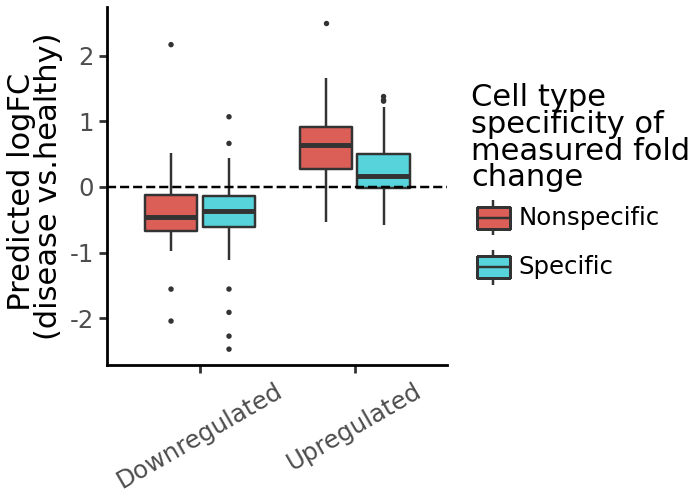

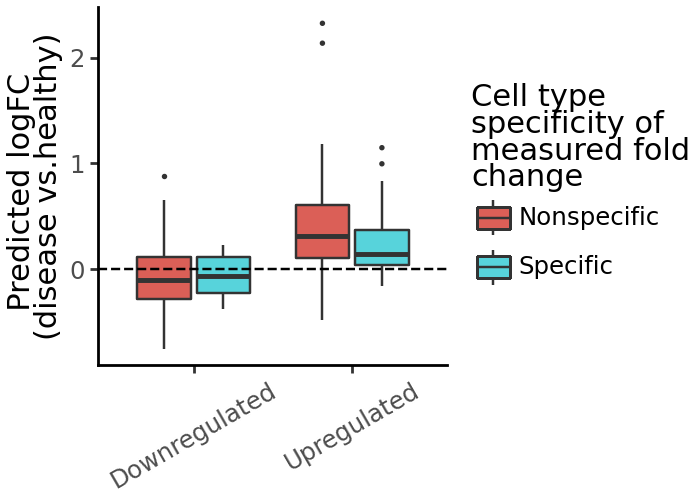

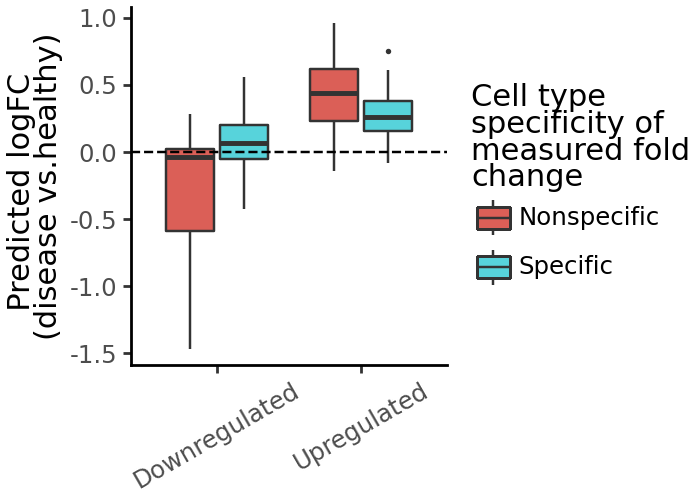

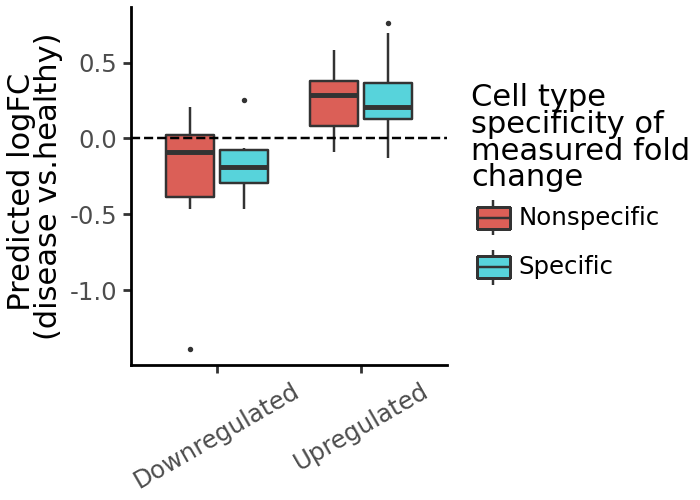

In [126]:
display(p1)
display(p2)
display(p3)
display(p4)

## Visualize logos

In [45]:
pos = dict()
with h5py.File('/gstore/data/resbioai/grelu/decima/results/ensemble/Crohns_disease__enterocyte__ileum__17481d16_ee44_49e5_bcf0_28c0780d8c4a/modisco_full/modisco_report.h5', 'r') as f:
    for key in f['pos_patterns']:
        pos[key] = np.array(f['pos_patterns'][key]['contrib_scores'])

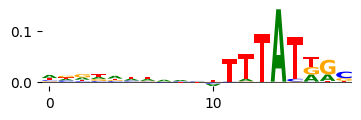

In [96]:
t = trim_pwm(pos['pattern_4'], 0.09)
plot_attributions(np.flip(t.T, axis=(0, 1)), figsize=(4, 1))

In [98]:
motifs, names = read_meme_file('../H12CORE_meme_format.meme')

In [105]:
np.where(['CDX1' in x for x in names])

(array([69, 70]),)

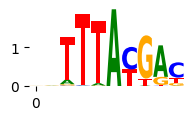

In [108]:
plot_logo(motifs[69])